In [0]:
%%capture
!pip install ipywidgets
!pip install higra

import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import random as r

import h5py

import higra as hg
from higra import HorizontalCutExplorer,HorizontalCutNodes, CptHierarchy

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import time

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [0]:
class CREMIDataset(Dataset):
    """CREMI Dataset"""

    def __init__(self, hdf_file, img_dir, seg_dir, transform=None):
        """
        Args:
            hdf_file (string): Path to the hdf file with the data.
            img_dir (string): Directory with all the images.
            seg_dir (string): Directory with all the associated segmentation.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.hdf = h5py.File(hdf_file, 'r')
        self.img_dir = img_dir
        self.seg_dir = seg_dir
        self.transform = transform
        self.image_shape = self.hdf[self.img_dir][0].shape

    def __len__(self):
        return self.hdf[self.img_dir].shape[0]

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        #Fuse all ndarrays into one and normalize
        image = np.stack([self.hdf[self.img_dir][idx]],axis=0)/255
        #Change type since original type (uint64) is not supported
        segment = np.stack(self.hdf[self.seg_dir][idx],axis=0).astype(np.int64)

        sample = {'image': image, 'segmentation': segment}

        if self.transform:
            sample = self.transform(sample)

        return sample

In [0]:
filename = '../CREMI datasets/sample_A_20160501.hdf' 
#filename = '../CREMI datasets/sample_B_20160501.hdf' 
dataset = CREMIDataset(filename,'volumes/raw','volumes/labels/neuron_ids')

# Architecture to use

In [0]:
class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    self.relu = nn.ReLU()
    self.conv1 = nn.Conv2d(1,8,5, padding=2) #padding = (kernel-1)/2
    self.conv1_bn = nn.BatchNorm2d(8)
    self.conv2 = nn.Conv2d(8,32,5, padding=2)
    self.conv2_bn = nn.BatchNorm2d(32)
    self.conv3 = nn.Conv2d(32,32,5, padding=2)
    self.conv3_bn = nn.BatchNorm2d(32)
    self.conv4 = nn.Conv2d(32,32,5, padding=2)
    self.conv4_bn = nn.BatchNorm2d(32)
    self.conv5 = nn.Conv2d(32,8,5, padding=2)
    self.conv5_bn = nn.BatchNorm2d(8)
    self.conv6 = nn.Conv2d(8,2,5, padding=2)
    self.sigmoid = nn.Sigmoid()


  def forward(self, x):
    x = self.relu(self.conv1_bn(self.conv1(x)))
    x = self.relu(self.conv2_bn(self.conv2(x)))
    x = self.relu(self.conv3_bn(self.conv3(x)))
    x = self.relu(self.conv4_bn(self.conv4(x)))
    x = self.relu(self.conv5_bn(self.conv5(x)))
    x = self.sigmoid(self.conv6(x))

    return x


model = Net().to(device)
model.load_state_dict(torch.load("./model_bn.pt"), strict=False)
model.eval()
summary(model, (1,21,21))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 21, 21]             208
       BatchNorm2d-2            [-1, 8, 21, 21]              16
              ReLU-3            [-1, 8, 21, 21]               0
            Conv2d-4           [-1, 32, 21, 21]           6,432
       BatchNorm2d-5           [-1, 32, 21, 21]              64
              ReLU-6           [-1, 32, 21, 21]               0
            Conv2d-7           [-1, 32, 21, 21]          25,632
       BatchNorm2d-8           [-1, 32, 21, 21]              64
              ReLU-9           [-1, 32, 21, 21]               0
           Conv2d-10           [-1, 32, 21, 21]          25,632
      BatchNorm2d-11           [-1, 32, 21, 21]              64
             ReLU-12           [-1, 32, 21, 21]               0
           Conv2d-13            [-1, 8, 21, 21]           6,408
      BatchNorm2d-14            [-1, 8,

# Utility function

In [0]:
def get_patches_from_image(image, patch_size, stride=None):
  if stride == None:
    stride = patch_size
  n_patches = (image.shape[1]-patch_size)//stride + 1
  patches = []

  add_border = False
  if image.shape[1]-patch_size % stride != 0:
      add_border = True

  for i in range(0,image.shape[1]-patch_size,stride):
    for j in range(0,image.shape[1]-patch_size,stride):
       patches.append(image[...,i:i+patch_size,j:j+patch_size])
    if add_border :
        patches.append(image[...,i:i+patch_size,-patch_size:])
  if add_border :
    for j in range(0,image.shape[1]-patch_size,stride):
      patches.append(image[...,-patch_size:,j:j+patch_size])
    patches.append(image[...,-patch_size:,-patch_size:])
  return patches

In [0]:
def get_image_from_patches(patches, patch_size,image_size, stride=None):
    if stride == None:
        stride = patch_size
    overlap = (patch_size - stride) // 2 
    im = np.zeros(image_size)
    n_patches = int(np.sqrt(len(patches))) - 1
    
    if image_size[1]-patch_size % stride != 0:
      add_border = True
    im_size = n_patches 
    for i in range(0,image_size[0]-patch_size,stride):
        ip = i//stride
        for j in range(0,image_size[1]-patch_size,stride):  
            jp = j//stride
            im[i+overlap:i+patch_size-overlap,j+overlap:j+patch_size-overlap] = \
              patches[ip*n_patches+jp+ip,overlap:patch_size-overlap,overlap:patch_size-overlap]
            
            # Add pixels on borders
            if i == 0 and overlap>0 :
              im[:overlap,j+overlap:j+patch_size-overlap] = \
                patches[jp,:overlap,overlap:patch_size-overlap]       
            if j == 0 and overlap>0:
              im[i+overlap:i+patch_size-overlap,:overlap] = \
                patches[ip*n_patches+ip,overlap:patch_size-overlap,:overlap]
        if add_border :
            im[i+overlap:i+patch_size-overlap,-overlap-stride:] = \
              patches[ip*n_patches+ip+jp+1,overlap:patch_size-overlap,-overlap-stride:]
    
    # If we have padding patches due to dimensions mismatch
    if add_border :
        for j in range(0,image_size[1]-patch_size,stride):
            im[-overlap-stride:,j+overlap:j+patch_size-overlap] = \
              patches[(n_patches+1)*n_patches+j//stride,-overlap-stride:,overlap:patch_size-overlap]
    if overlap > 0 :
    #Still need to fix corners
        im[:overlap,:overlap] = patches[0,:overlap,:overlap]
        im[-overlap-stride:,:overlap] = patches[patches.shape[0]-n_patches-1,-overlap-stride:,:overlap]
        im[:overlap,-overlap-stride:] = patches[n_patches,:overlap,-overlap-stride:]   
    im[-overlap-stride:,-overlap-stride:] = patches[-1,-overlap-stride:,-overlap-stride:]

    return im


# Predict


In [0]:
dataloader = torch.utils.data.DataLoader(dataset, batch_size=1,shuffle=False, num_workers=1)

In [0]:
def predict_whole_image_lazy():
    total = np.zeros(shape=(125,1250,1250))
    for i,image in enumerate(dataloader):
        print("Image number : ",i)
        image = image["image"][0]
        patches = get_patches_from_image(image,21,7)


        for j in range(0,len(patches),1000):
            ims = [torch.tensor(patch) for patch in patches[j:j+1000]]
            inputs = torch.stack(ims)
            inputs = inputs.to(device=device, dtype=torch.float)
            preds = model(inputs)
            if j == 0:
                preds_x = preds[:,0].cpu().detach().numpy()
                preds_y = preds[:,1].cpu().detach().numpy()
            else:
                preds_x=np.concatenate((preds_x,preds[:,0].cpu().detach().numpy()))
                preds_y=np.concatenate((preds_y,preds[:,1].cpu().detach().numpy()))

        grad_x = get_image_from_patches(preds_x,21,(1250,1250),7)
        grad_y = get_image_from_patches(preds_y,21,(1250,1250),7)
        #del preds_x
        #del preds_y
        
        thresh = 0.9

        grad = (grad_x+grad_y)/2
        grad[grad>thresh]=1
        grad[grad<=thresh] = 0

        total[i] = grad
    return total

In [0]:
total = predict_whole_image_lazy()

Image number :  0


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # Remove the CWD from sys.path while we load stuff.


Image number :  1
Image number :  2
Image number :  3
Image number :  4
Image number :  5
Image number :  6
Image number :  7
Image number :  8
Image number :  9
Image number :  10
Image number :  11
Image number :  12
Image number :  13
Image number :  14
Image number :  15
Image number :  16
Image number :  17
Image number :  18
Image number :  19
Image number :  20
Image number :  21
Image number :  22
Image number :  23
Image number :  24
Image number :  25
Image number :  26
Image number :  27
Image number :  28
Image number :  29
Image number :  30
Image number :  31
Image number :  32
Image number :  33
Image number :  34
Image number :  35
Image number :  36
Image number :  37
Image number :  38
Image number :  39
Image number :  40
Image number :  41
Image number :  42
Image number :  43
Image number :  44
Image number :  45
Image number :  46
Image number :  47
Image number :  48
Image number :  49
Image number :  50
Image number :  51
Image number :  52
Image number :  53
Im

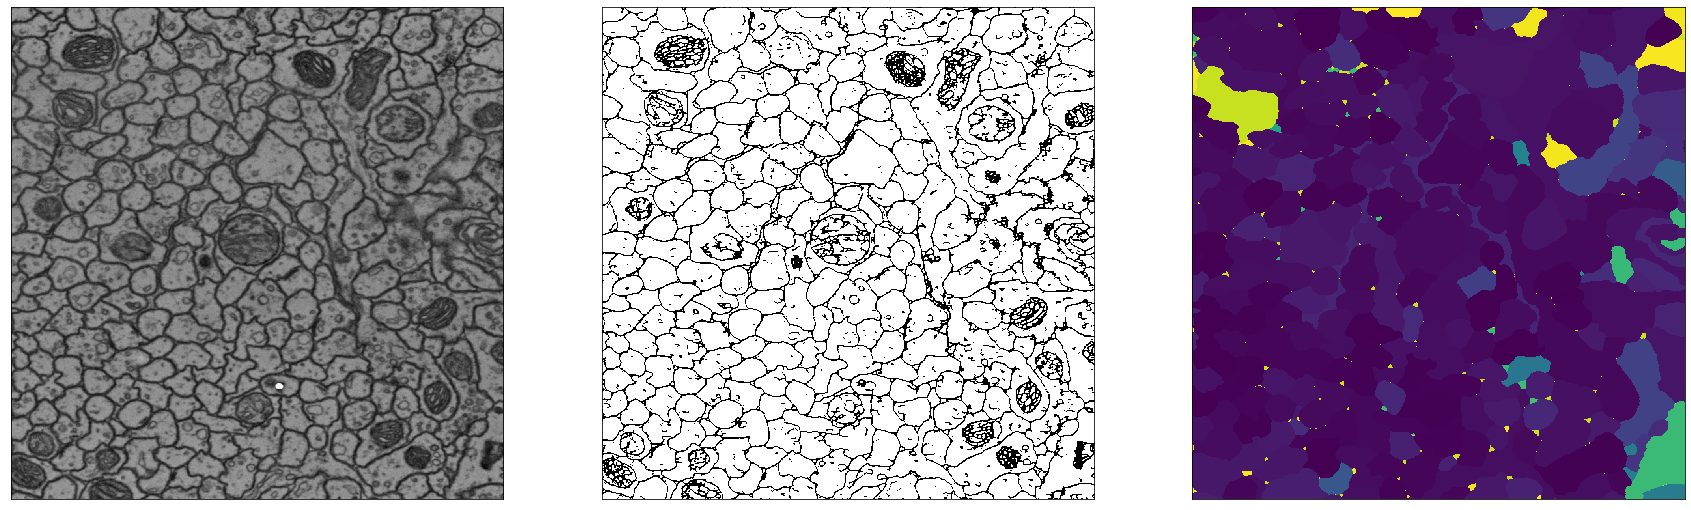

In [0]:
plt.figure(figsize=(30,20))
plt.subplot(131)
plt.xticks([])
plt.yticks([])
plt.imshow(dataset[100]['image'][0],cmap="gray")

plt.subplot(132)
plt.xticks([])
plt.yticks([])
plt.imshow(total[100],cmap="gray")

plt.subplot(133)
plt.xticks([])
plt.yticks([])
plt.imshow(dataset[100]['segmentation'])

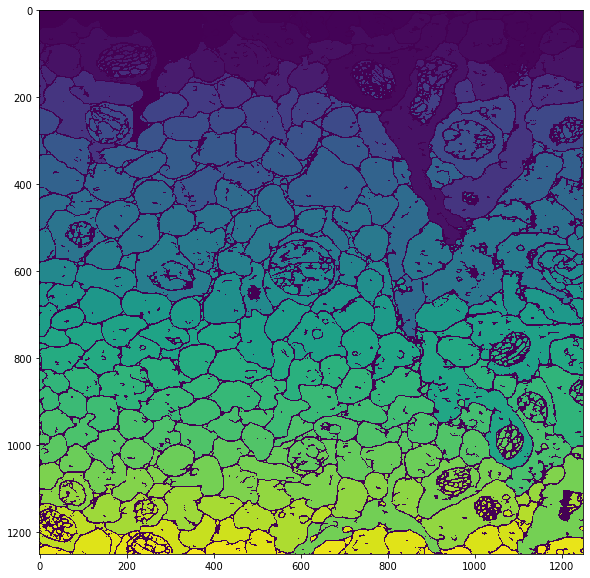

In [0]:
import scipy.ndimage
labeled = np.zeros(shape=(125,1250,1250))
for i in range(labeled.shape[0]):
    im = scipy.ndimage.measurements.label(total[i])[0]
    labeled[i]=im
#labeled = scipy.ndimage.measurements.label(total)[0]
#print(labeled.shape)

plt.figure(figsize=(10,10))
plt.imshow(labeled[100])

(1250, 1250)
(1559,)


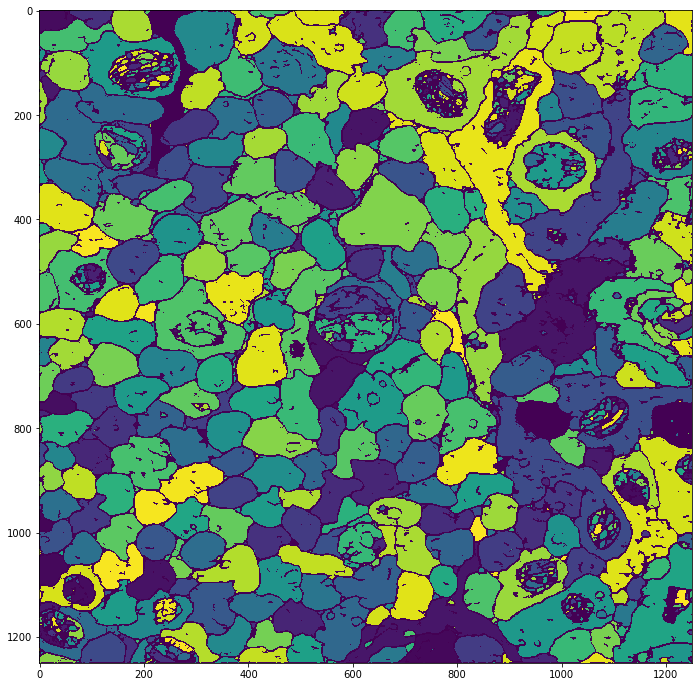

In [0]:
import cv2
#ret, labels = cv2.connectedComponents((dataset[0]*255).astype(np.uint8))
labels = labeled[100].astype(np.uint64)
print(labels.shape)
lut = np.unique(labels)
print(lut.shape)
np.random.shuffle(lut)
lut[lut==lut[0]] = 12000
lut[0] = 0
colored = lut[labels]*5

plt.figure(figsize=(12,12))
plt.imshow(colored)

In [0]:
from cremi import Annotations, Volume
from cremi.io import CremiFile

file = CremiFile("Results_A_test.hdf", "w")

# Write volumes representing the neuron segmentation.
neuron_ids = Volume(labeled, resolution=(40.0, 4.0, 4.0))
file.write_neuron_ids(neuron_ids)
file.close()